In [1]:
!pip install scipy
!pip install tensorflow_datasets
!pip install opencv-contrib-python-headless

     |████████████████████████████████| 43.4 MB 8.5 MB/s eta 0:00:012   |███████▏                        | 9.8 MB 8.0 MB/s eta 0:00:05
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 4.7 MB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 5.5 MB/s  eta 0:00:01
     |████████████████████████████████| 95 kB 4.8 MB/s eta 0:00:011
     |████████████████████████████████| 78 kB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 211 kB 9.1 MB/s eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21485 sha256=5d6cf28dfb29be4ab3b97228a3679129a65d84821082556d74a54df76fbe7be3
  Stored in directory: /root/.cache/pip/wheels/54/aa/01/724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
Successfully built promise
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrad

In [2]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2
%matplotlib inline

In [3]:
data_dir = "/MyProjects/data/caltech_birds/"

In [4]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.
    
    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
                           
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).
    
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image

In [5]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)
        
        
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [6]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
    return image, bbox_list

In [7]:
def read_image_with_shape(image, bbox):
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list

In [8]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, bbox_list

In [9]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

In [10]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_path='/MyProjects/data/caltech_birds/caltech_birds2010/0.1.1',
    file_format=tfrecord,
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.st

<ipython-input-9-116a267219de>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (np.array(ds_images), np.array(ds_bboxes))


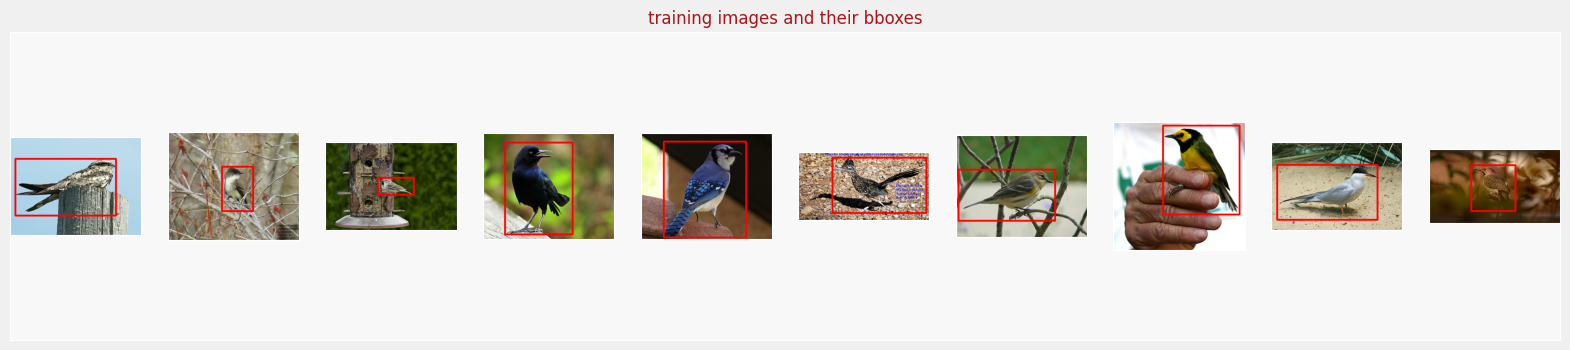

In [11]:
def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=False)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, 
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

In [22]:
visualization_training_images[0].shape

(375, 500, 3)

<ipython-input-9-116a267219de>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (np.array(ds_images), np.array(ds_bboxes))


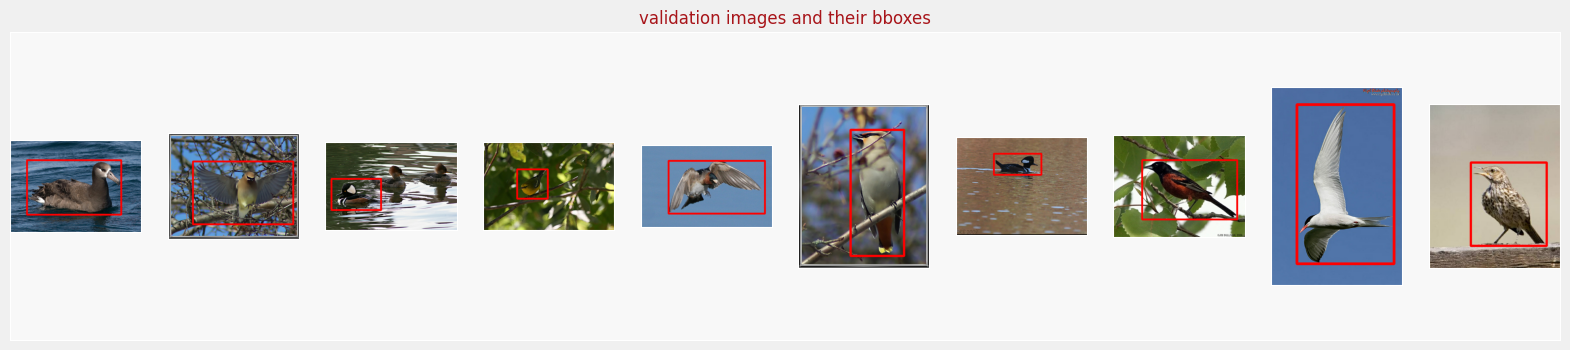

In [12]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", data_dir=data_dir, download=False)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

In [20]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

In [13]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

def dense_layers(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    return x

def bounding_box_regression(x):
    bounding_box_regression_output = tf.keras.layers.Dense(4, activation="relu")(x)
    return bounding_box_regression_output

def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    last_dense_layer = dense_layers(feature_cnn) 
    bounding_box_output = bounding_box_regression(last_dense_layer)
    model = tf.keras.Model(inputs=inputs, outputs = bounding_box_output)    
    
    return model

In [ ]:
def define_and_compile_model():
    inputs = tf.keras.layers.Input(shape=(375,500,3))
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
    
    # create the model
    model = final_model(inputs)
    
    # compile your model
    None

    ### END CODE HERE ###
    

    return model